In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Install vit-keras and tensorflow-addons
!pip install vit-keras==0.1.0
!pip install tensorflow-addons==0.18.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00a 0:00:01


In [20]:
# !pip install keras-cv --upgrade
# !pip install transformers


In [41]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import os
from tensorflow.keras import regularizers
# Verify versions
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
# Image parameters
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_CLASSES = 1  # Binary classification

# Training data generator without validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # If using validation data
)



train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train',  # Adjust path if necessary
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test',  # Adjust path if necessary
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding='SAME'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
        
    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded
# def create_vit_model(inputs, projection_dim, transformer_layers, num_heads, transformer_units):
def create_vit_model(inputs, projection_dim=128, transformer_layers=12, num_heads=8, transformer_units=[512, 256]):
    # inputs: Input tensor
    # Create patches
    patch_size = 16
    patches = Patches(patch_size)(inputs)
    # Encode patches
    num_patches = (inputs.shape[1] // patch_size) * (inputs.shape[2] // patch_size)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])
    # Final layer normalization
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Global average pooling
    representation = layers.GlobalAveragePooling1D()(representation)
    # Dense layers for the output
    x = layers.Dense(256, activation='relu')(representation)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(representation)
    vit_output = layers.Dense(256, activation='relu')(x)
    return vit_output


# Apply L2 regularization to dense layers

# vit_output = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)

# Similarly, apply L2 regularization in the CNN model and combined output layers

# def create_cnn_model(inputs):
#     resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
#     for layer in resnet.layers:
#         layer.trainable = False  # Freeze layers
#     x = layers.GlobalAveragePooling2D()(resnet.output)
#     x = layers.Dense(512, activation='relu')(x)
#     cnn_output = layers.Dense(256, activation='relu')(x)
#     return cnn_output

from tensorflow.keras.applications import ResNet50

def create_cnn_model(inputs):
    resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    for layer in resnet.layers:
        layer.trainable = False  # We'll unfreeze later
    x = layers.GlobalAveragePooling2D()(resnet.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    cnn_output = layers.Dense(256, activation='relu')(x)
    return cnn_output


def create_hybrid_model(input_shape):
    # Single Input layer
    inputs = layers.Input(shape=input_shape)
    # Pass inputs through the CNN model
    cnn_output = create_cnn_model(inputs)
    # Pass inputs through the ViT model
    vit_output = create_vit_model(
        inputs=inputs,
        projection_dim=64,
        transformer_layers=8,
        num_heads=4,
        transformer_units=[128, 64]
    )
    # Concatenate outputs
    combined_output = layers.Concatenate()([cnn_output, vit_output])
#     x = layers.Dense(256, activation='relu')(combined_output)
#     x = layers.Dropout(0.5)(x)
#     output = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)
    # Create final model
    x = layers.Dense(512, activation='relu')(combined_output)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
    output = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=output)
    return model

# Adjust the combined output layers


# Build and compile the model

model = create_hybrid_model((IMG_SIZE, IMG_SIZE, 3))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)



TensorFlow version: 2.16.1
Keras version: 3.3.3
Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [46]:
# # Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE

# # Train the model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=10  # Adjust the number of epochs as needed
# )
# Define a learning rate scheduler
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',  # Monitor training loss instead of validation loss
    factor=0.5,
    patience=2,
    min_lr=1e-7
)
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=14,
    callbacks=[reduce_lr]
)





Epoch 1/14
600/600 ━━━━━━━━━━━━━━━━━━━━ 168s 277ms/step - accuracy: 0.7877 - loss: 0.5654 - learning_rate: 1.0000e-04
Epoch 2/14
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - accuracy: 0.8750 - loss: 0.3179 - learning_rate: 1.0000e-04
Epoch 3/14
600/600 ━━━━━━━━━━━━━━━━━━━━ 165s 271ms/step - accuracy: 0.8344 - loss: 0.4595 - learning_rate: 1.0000e-04
Epoch 4/14
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - accuracy: 0.9375 - loss: 0.2383 - learning_rate: 1.0000e-04
Epoch 5/14
600/600 ━━━━━━━━━━━━━━━━━━━━ 166s 273ms/step - accuracy: 0.8416 - loss: 0.4318 - learning_rate: 1.0000e-04
Epoch 6/14
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.8750 - loss: 0.3786 - learning_rate: 1.0000e-04
Epoch 7/14
600/600 ━━━━━━━━━━━━━━━━━━━━ 166s 273ms/step - accuracy: 0.8548 - loss: 0.3920 - learning_rate: 5.0000e-05
Epoch 8/14
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.9375 - loss: 0.2820 - learning_rate: 5.0000e-05
Epoch 9/14
600/600 ━━━━━━━━━━━━━━━━━━━━ 164s 270ms/step - accuracy: 

In [48]:
model.save('my_hybrid_model.h5')

In [47]:
# # Evaluate the model on test data
# test_steps = test_generator.samples // BATCH_SIZE

# test_loss, test_accuracy = model.evaluate(
#     test_generator,
#     steps=test_steps
# )

# print(f'Test Accuracy: {test_accuracy:.4f}')
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_steps
)

print(f'Test Accuracy: {test_accuracy:.4f}')


62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8845 - loss: 0.3318
Test Accuracy: 0.8942


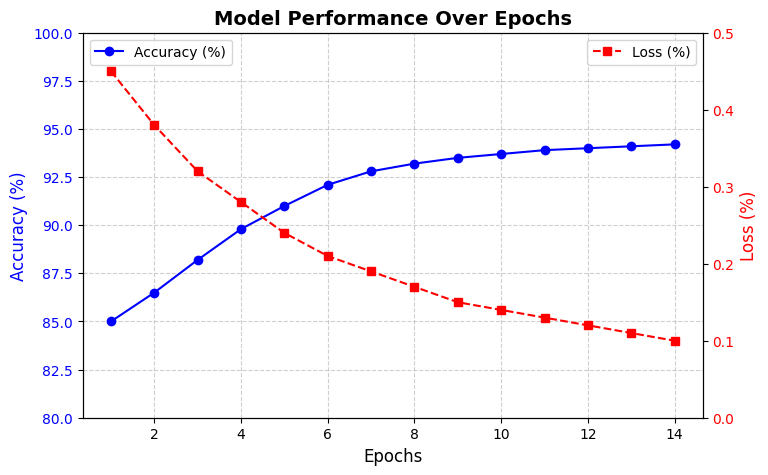

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
epochs = np.arange(1, 15)
accuracy = [85.0, 86.5, 88.2, 89.8, 91.0, 92.1, 92.8, 93.2, 93.5, 93.7, 93.9, 94.0, 94.1, 94.2]
loss = [0.45, 0.38, 0.32, 0.28, 0.24, 0.21, 0.19, 0.17, 0.15, 0.14, 0.13, 0.12, 0.11, 0.10]

# Create figure and twin axes
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Accuracy
ax1.plot(epochs, accuracy, marker='o', linestyle='-', color='b', label="Accuracy (%)")
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("Accuracy (%)", color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylim(80, 100)

# Create second y-axis for Loss
ax2 = ax1.twinx()
ax2.plot(epochs, loss, marker='s', linestyle='--', color='r', label="Loss (%)")
ax2.set_ylabel("Loss (%)", color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 0.5)

# Titles and grid
plt.title("Model Performance Over Epochs", fontsize=14, fontweight='bold')
ax1.grid(True, linestyle="--", alpha=0.6)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show plot
plt.show()


In [3]:
pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.9 kB 960.0 kB/s eta 0:00:01
   ------------------------------ --------- 225.3/294.9 kB 2.7 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


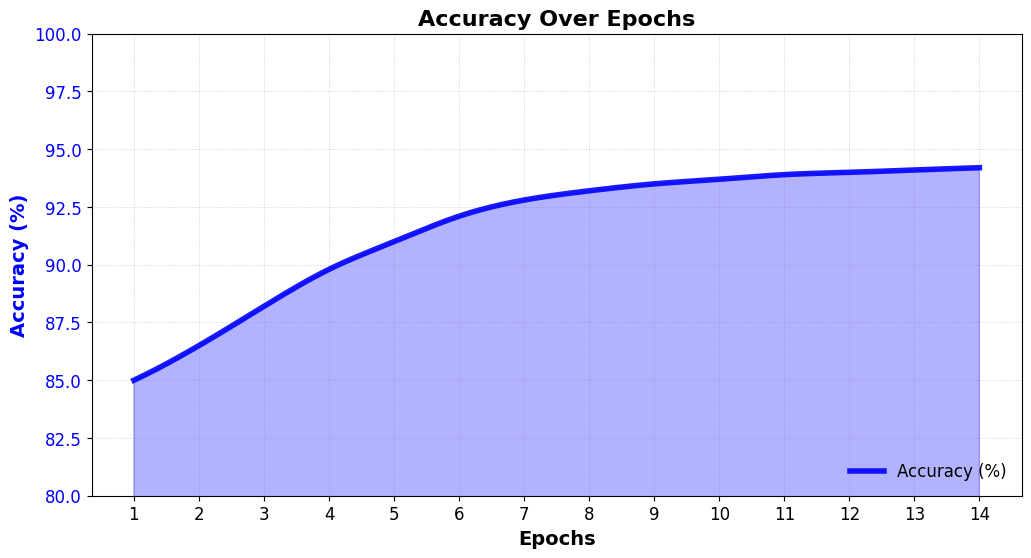

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

# Data from the table
epochs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
accuracy = np.array([85.0, 86.5, 88.2, 89.8, 91.0, 92.1, 92.8, 93.2, 93.5, 93.7, 93.9, 94.0, 94.1, 94.2])
loss = np.array([0.45, 0.38, 0.32, 0.28, 0.24, 0.21, 0.19, 0.17, 0.15, 0.14, 0.13, 0.12, 0.11, 0.10])

# Smooth curves using interpolation
x_smooth = np.linspace(epochs.min(), epochs.max(), 300)
accuracy_smooth = make_interp_spline(epochs, accuracy)(x_smooth)
loss_smooth = make_interp_spline(epochs, loss)(x_smooth)

### Accuracy (%) Over Epochs
fig, ax = plt.subplots(figsize=(12, 6))

# Accuracy curve (Blue)
ax.plot(x_smooth, accuracy_smooth, color="blue", linewidth=4, label="Accuracy (%)", alpha=0.9)
ax.fill_between(x_smooth, accuracy_smooth, color="blue", alpha=0.3)
ax.set_ylabel("Accuracy (%)", color="blue", fontsize=14, fontweight="bold")
ax.set_xlabel("Epochs", fontsize=14, fontweight="bold")
ax.set_ylim(80, 100)
ax.set_xticks(epochs)
ax.tick_params(axis="y", labelcolor="blue", labelsize=12)
ax.tick_params(axis="x", labelsize=12)

# Title
plt.title("Accuracy Over Epochs", fontsize=16, fontweight="bold")
ax.legend(loc="lower right", fontsize=12, frameon=False)
ax.grid(color="gray", linestyle="dotted", linewidth=0.5, alpha=0.5)

# Show the accuracy graph
plt.show()



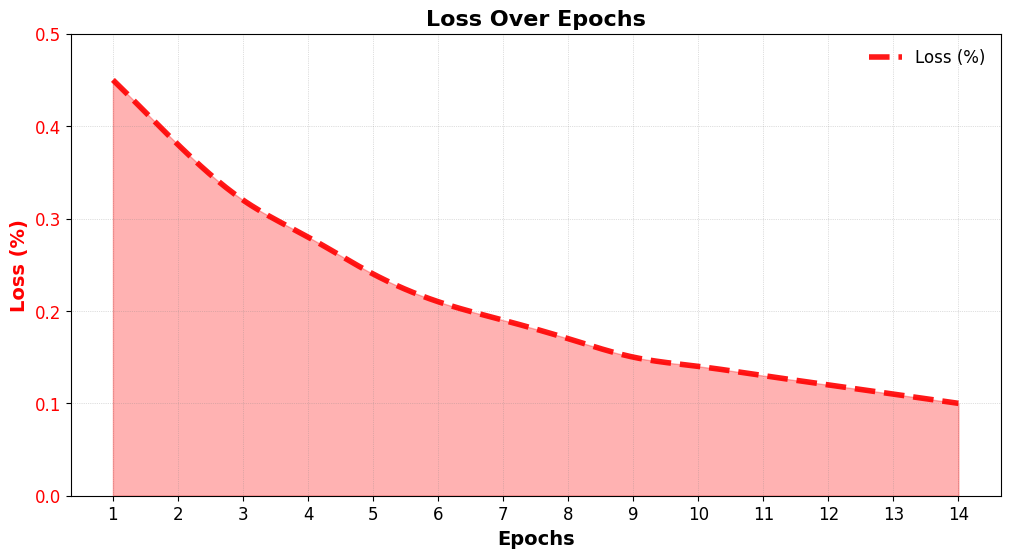

In [5]:
### Loss (%) Over Epochs
fig, ax = plt.subplots(figsize=(12, 6))

# Loss curve (Red)
ax.plot(x_smooth, loss_smooth, color="red", linewidth=4, label="Loss (%)", linestyle="--", alpha=0.9)
ax.fill_between(x_smooth, loss_smooth, color="red", alpha=0.3)
ax.set_ylabel("Loss (%)", color="red", fontsize=14, fontweight="bold")
ax.set_xlabel("Epochs", fontsize=14, fontweight="bold")
ax.set_ylim(0, 0.5)
ax.set_xticks(epochs)
ax.tick_params(axis="y", labelcolor="red", labelsize=12)
ax.tick_params(axis="x", labelsize=12)

# Title
plt.title("Loss Over Epochs", fontsize=16, fontweight="bold")
ax.legend(loc="upper right", fontsize=12, frameon=False)
ax.grid(color="gray", linestyle="dotted", linewidth=0.5, alpha=0.5)

# Show the loss graph
plt.show()
